Image manipulation demonstration created by Alex Frye, for use in Dr. Hoover's EE/CENG 441/541 Computer Vision class

In [1]:
import skimage
from skimage import io
from skimage import data
from skimage.transform import resize
from skimage.transform import rotate
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as LA
import time
from scipy import signal
from scipy import linalg
from scipy.ndimage import gaussian_filter
import cv2

from Final_Project_lib import *

In [2]:
header = 'Bookshelf_Images/'
im_num_group = 4
im_per_group = 4
im_foot = '.jpg'

im_bookshelf = []
im_bookshelf_gray = []
for i in range(im_num_group):
    im_bookshelf.append([])
    im_bookshelf_gray.append([])
    for j in range(im_per_group):
        temp = io.imread(header + str(i) + '_' + str(j) + im_foot)
        im_bookshelf[i].append(temp)
        temp = io.imread(header + str(i) + '_' + str(j) + im_foot, as_gray = True)
        im_bookshelf_gray[i].append(temp)

In [3]:
img1 = cv2.imread('Bookshelf_Images/3_1.jpg',0)          # queryImage
img2 = cv2.imread('Bookshelf_Images/3_2.jpg',0) # trainImage
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

In [4]:
def draw_matches(img1, kp1, img2, kp2, matches, color=None): 
    """Draws lines between matching keypoints of two images.  
    Keypoints not in a matching pair are not drawn.
    Places the images side by side in a new image and draws circles 
    around each keypoint, with line segments connecting matching pairs.
    You can tweak the r, thickness, and figsize values as needed.
    Args:
        img1: An openCV image ndarray in a grayscale or color format.
        kp1: A list of cv2.KeyPoint objects for img1.
        img2: An openCV image ndarray of the same format and with the same 
        element type as img1.
        kp2: A list of cv2.KeyPoint objects for img2.
        matches: A list of DMatch objects whose trainIdx attribute refers to 
        img1 keypoints and whose queryIdx attribute refers to img2 keypoints.
        color: The color of the circles and connecting lines drawn on the images.  
        A 3-tuple for color images, a scalar for grayscale images.  If None, these
        values are randomly generated.  
    """
    # We're drawing them side by side.  Get dimensions accordingly.
    # Handle both color and grayscale images.
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1])
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]:img1.shape[1]+img2.shape[1]] = img2
    
    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    r = 15
    thickness = 20
    if color:
        c = color
    for m in matches:
        # Generate random color for RGB/BGR and grayscale images as needed.
        if not color: 
            c = np.random.randint(0,256,3) if len(img1.shape) == 3 else np.random.randint(0,256)
        # So the keypoint locs are stored as a tuple of floats.  cv2.line(), like most other things,
        # wants locs as a tuple of ints.
        end1 = tuple(np.round(kp1[m.trainIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m.queryIdx].pt).astype(int) + np.array([img1.shape[1], 0]))
        cv2.line(new_img, end1, end2, c, thickness)
        cv2.circle(new_img, end1, r, c, thickness)
        cv2.circle(new_img, end2, r, c, thickness)
    
    plt.figure(figsize=(15,15))
    plt.imshow(new_img, cmap='gray')
    plt.show()

(3, 3, 4032)

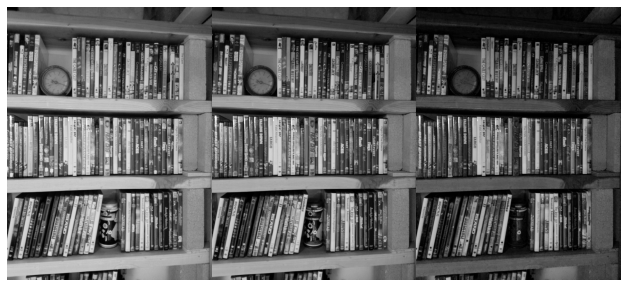

In [34]:
ajacent_images([im_bookshelf[3][0][:,:,0], im_bookshelf[3][0][:,:,1], im_bookshelf[3][0][:,:,2]])

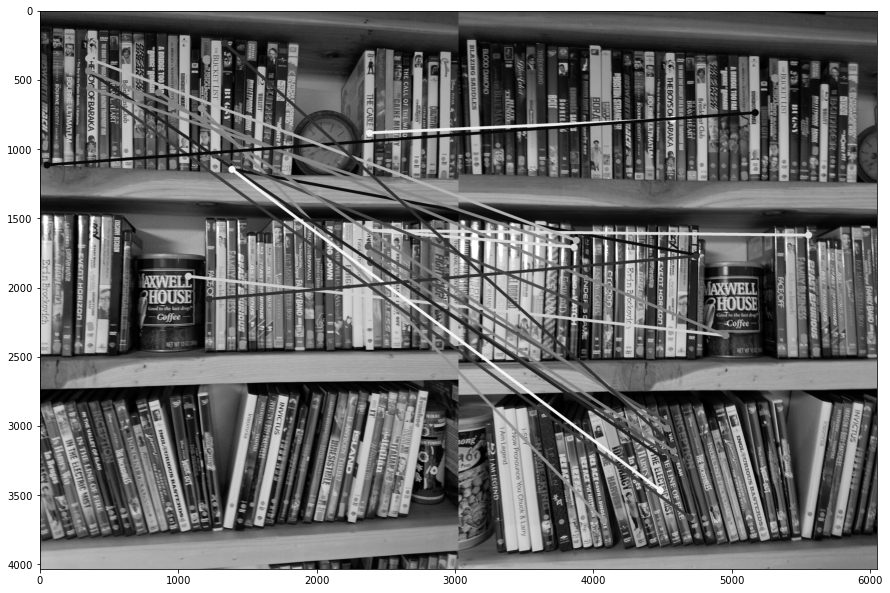

In [5]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = draw_matches(img1,kp1,img2,kp2,matches[:20])

In [15]:
def cut_down_descriptors(desc, max_num, max=True):
    if max and len(desc[:,2]) > max_num:
        args = np.argsort(desc[:,2])
        temp = desc[np.array(args[-max_num:])]
        return temp
    elif max:
        return desc
    else:
        return desc[:max_num]

0 out of 18
1 out of 18
3 out of 18
5 out of 18
7 out of 18
9 out of 18
10 out of 18
12 out of 18
14 out of 18
16 out of 18
18 out of 18


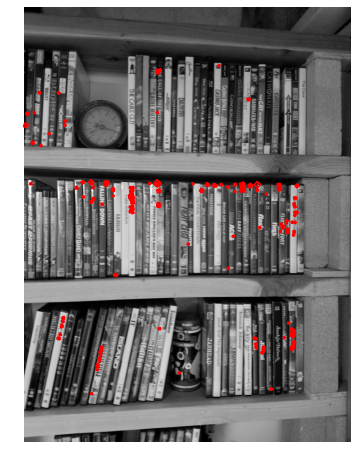

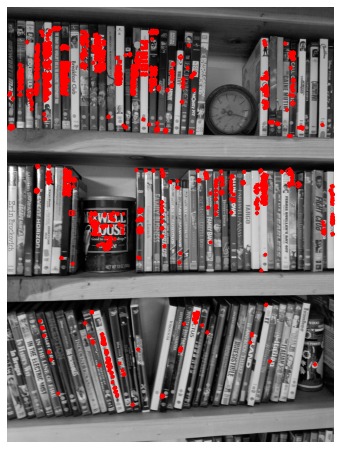

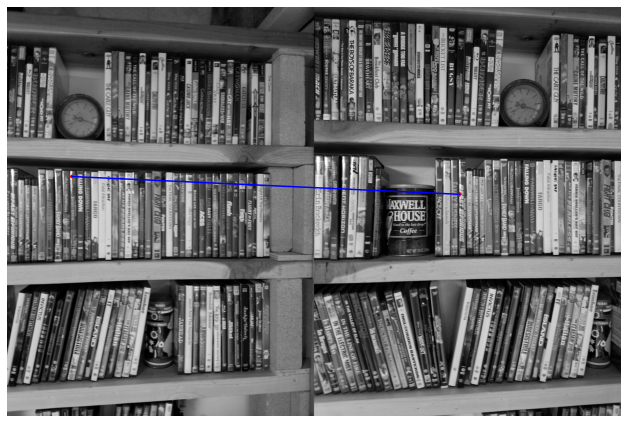

In [25]:
im0 = im_bookshelf_gray[3][0]
im1 = im_bookshelf_gray[3][1]
[im0, im1] = make_images_same_size([im0, im1])

d0 = features_descriptors(im0, s1=1, s2=2, pix_dist=3, threshold=0.3)
d1 = features_descriptors(im1, s1=1, s2=2, pix_dist=3, threshold=0.3)

n_feat = 1000
d0_sm = cut_down_descriptors(d0, n_feat)
d1_sm = cut_down_descriptors(d1, n_feat)

plot_boxes_desc(d0_sm, im0)
plot_boxes_desc(d1_sm, im1)

matches = np.array(compare_features_threshold(d0, d1, threshold=0.03))
connect_features(matches, im0, im1)

In [16]:
#args = np.argsort(d1[:,2])
#print(args)
#print(np.array(args[-100:]))
#d1_sm = d1[np.array(args[-100:])]
n_feat = 1000
d0_sm = cut_down_descriptors(d0, n_feat, False)
d1_sm = cut_down_descriptors(d1, n_feat, False)

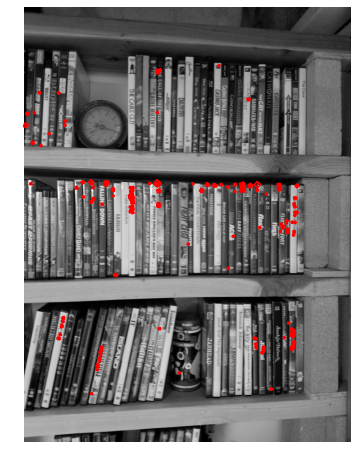

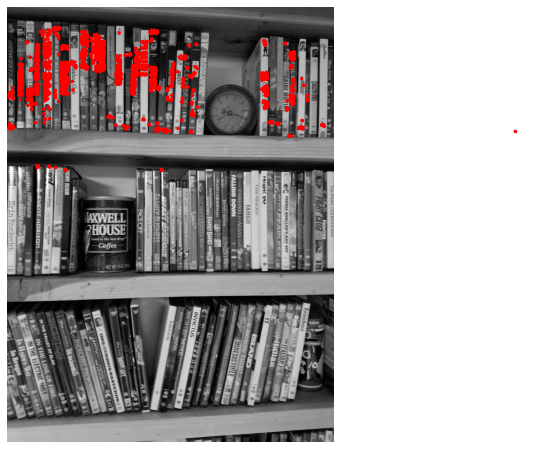

In [17]:
plot_boxes_desc(d0_sm, im0)
plot_boxes_desc(d1_sm, im1)

0 out of 18
1 out of 18
3 out of 18
5 out of 18
7 out of 18
9 out of 18
10 out of 18
12 out of 18
14 out of 18
16 out of 18
18 out of 18


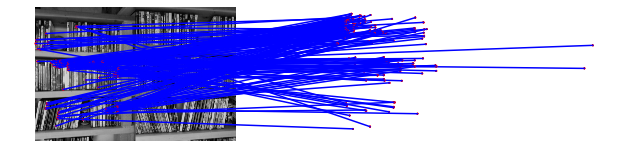

In [22]:
matches = np.array(compare_features_threshold(d0, d1, threshold=0.1))
connect_features(matches, im0, im1)

In [11]:
arr = np.array([0, 4, 2])
arr2 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
print(arr2[arr])

[1 5 3]


In [12]:
np.min([100, 4])

4

In [13]:
print(np.arange(0, 100, 1)[-2:])

[98 99]
